# =============================================================================
# STEP 3: CUSTOMER CLUSTERING WITH K-MEANS
# Apply unsupervised ML to discover natural customer groupings
# =============================================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
RANDOM_STATE = 42

## 1. LOAD RFM DATA

In [3]:
rfm = pd.read_csv('../data/processed/rfm_data.csv')
print(f"Loaded {len(rfm)} customers with RFM metrics")

# Features for clustering (we'll use log-transformed versions for skewed data)
features = ['Recency', 'Frequency', 'Monetary']

# Check distributions
print("\nFeature distributions:")
print(rfm[features].describe())

Loaded 4311 customers with RFM metrics

Feature distributions:
           Recency    Frequency       Monetary
count  4311.000000  4311.000000    4311.000000
mean     91.132220     4.456275    2040.074826
std      96.836908     8.170877    8897.677431
min       1.000000     1.000000       2.950000
25%      18.000000     1.000000     307.975000
50%      53.000000     2.000000     705.650000
75%     136.000000     5.000000    1722.565000
max     374.000000   205.000000  349164.350000


## 2. FEATURE ENGINEERING FOR CLUSTERING

In [4]:
# Log transform to handle skewness (especially Monetary and Frequency)
rfm['Recency_log'] = np.log1p(rfm['Recency'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

# Additional features that might improve clustering
rfm['AvgOrderValue_log'] = np.log1p(rfm['AvgOrderValue'])

# Select features for clustering
cluster_features = ['Recency_log', 'Frequency_log', 'Monetary_log']
X = rfm[cluster_features]

print(f"\nClustering features: {cluster_features}")
print(f"Feature matrix shape: {X.shape}")


Clustering features: ['Recency_log', 'Frequency_log', 'Monetary_log']
Feature matrix shape: (4311, 3)


## 3. STANDARDIZATION (CRITICAL for K-Means)

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nScaled features mean: {X_scaled.mean(axis=0).round(3)}")
print(f"Scaled features std: {X_scaled.std(axis=0).round(3)}")


Scaled features mean: [-0.  0. -0.]
Scaled features std: [1. 1. 1.]


## 4. FIND OPTIMAL K (Elbow Method + Silhouette Score)


FINDING OPTIMAL NUMBER OF CLUSTERS
K=2: Inertia=6597, Silhouette=0.423
K=3: Inertia=4965, Silhouette=0.328
K=4: Inertia=3972, Silhouette=0.332
K=5: Inertia=3343, Silhouette=0.320
K=6: Inertia=2919, Silhouette=0.311
K=7: Inertia=2606, Silhouette=0.307
K=8: Inertia=2393, Silhouette=0.279
K=9: Inertia=2214, Silhouette=0.278
K=10: Inertia=2035, Silhouette=0.279


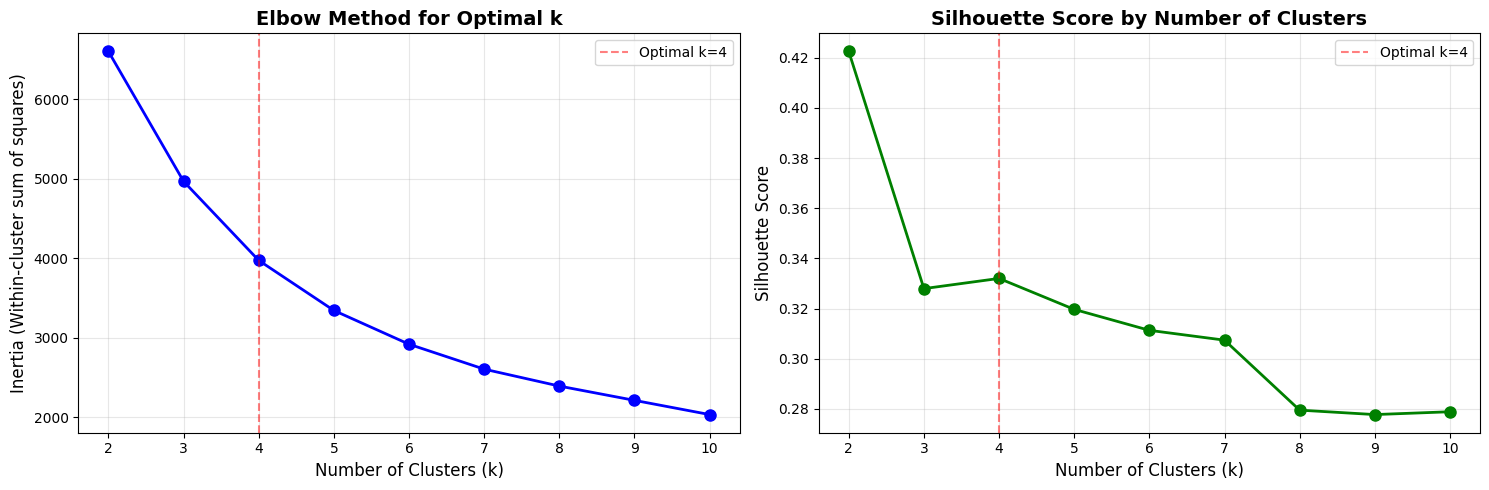


✅ Selected K=4 clusters


In [7]:
print("\n" + "="*60)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.0f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot Elbow and Silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=4, color='red', linestyle='--', alpha=0.5, label='Optimal k=4')
ax1.legend()

# Silhouette plot
ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score by Number of Clusters', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=4, color='red', linestyle='--', alpha=0.5, label='Optimal k=4')
ax2.legend()

plt.tight_layout()
plt.savefig('../reports/cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Choose optimal k (usually 4 or 5 for RFM)
optimal_k = 4  # Based on elbow and business interpretability
print(f"\n✅ Selected K={optimal_k} clusters")



## 5. APPLY K-MEANS CLUSTERING

In [8]:
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)

# Add cluster centers (inverse transform to original scale)
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(np.expm1(centers_original), columns=features)
centers_df['Cluster'] = range(optimal_k)
print("\nCluster Centers (Original Scale):")
print(centers_df)


Cluster Centers (Original Scale):
      Recency  Frequency     Monetary  Cluster
0   18.059255   1.868923   449.211434        0
1    8.736614  10.653530  3964.725749        1
2  159.820392   1.235025   236.073681        2
3   64.217838   3.826476  1414.507377        3


## 6. CLUSTER ANALYSIS & INTERPRETATION

In [9]:
print("\n" + "="*80)
print("CLUSTER ANALYSIS")
print("="*80)

cluster_summary = rfm.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum'],
    'AvgOrderValue': 'mean'
}).round(2)

cluster_summary.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue', 'Avg_Order_Value']
cluster_summary['Percentage'] = (cluster_summary['Count'] / len(rfm) * 100).round(1)
cluster_summary['Revenue_Share'] = (cluster_summary['Total_Revenue'] / cluster_summary['Total_Revenue'].sum() * 100).round(1)

# Sort by monetary value
cluster_summary = cluster_summary.sort_values('Avg_Monetary', ascending=False)
print(cluster_summary)


CLUSTER ANALYSIS
         Count  Avg_Recency  Avg_Frequency  Avg_Monetary  Total_Revenue  \
Cluster                                                                   
1          776        13.85          13.58       7386.79     5732148.47   
3         1202        81.58           4.13       1762.58     2118624.31   
0          944        23.39           2.02        553.67      522665.68   
2         1389       188.62           1.29        303.33      421324.11   

         Avg_Order_Value  Percentage  Revenue_Share  
Cluster                                              
1                  39.25        18.0           65.2  
3                  47.27        27.9           24.1  
0                  22.89        21.9            5.9  
2                  28.02        32.2            4.8  


## 7. NAME CLUSTERS BASED ON CHARACTERISTICS

In [10]:
def name_cluster(cluster_id):
    """Assign meaningful names based on cluster characteristics"""
    row = cluster_summary.loc[cluster_id]
    recency = row['Avg_Recency']
    frequency = row['Avg_Frequency']
    monetary = row['Avg_Monetary']
    
    if monetary > 3000 and recency < 50:
        return 'VIP Champions'
    elif monetary > 1000 and frequency > 5:
        return 'Loyal High-Value'
    elif recency < 100 and frequency < 3:
        return 'New Potentials'
    elif recency > 200:
        return 'At Risk / Churned'
    else:
        return 'Regular Customers'

# Apply names
cluster_names = {i: name_cluster(i) for i in range(optimal_k)}
rfm['Cluster_Name'] = rfm['Cluster'].map(cluster_names)
cluster_summary['Name'] = cluster_summary.index.map(cluster_names)

print("\n" + "="*80)
print("FINAL CLUSTER PROFILES")
print("="*80)
print(cluster_summary[['Name', 'Count', 'Percentage', 'Revenue_Share', 'Avg_Monetary']])


FINAL CLUSTER PROFILES
                      Name  Count  Percentage  Revenue_Share  Avg_Monetary
Cluster                                                                   
1            VIP Champions    776        18.0           65.2       7386.79
3        Regular Customers   1202        27.9           24.1       1762.58
0           New Potentials    944        21.9            5.9        553.67
2        Regular Customers   1389        32.2            4.8        303.33


## 8. VISUALIZATION: 3D CLUSTER PLOT (Using PCA)

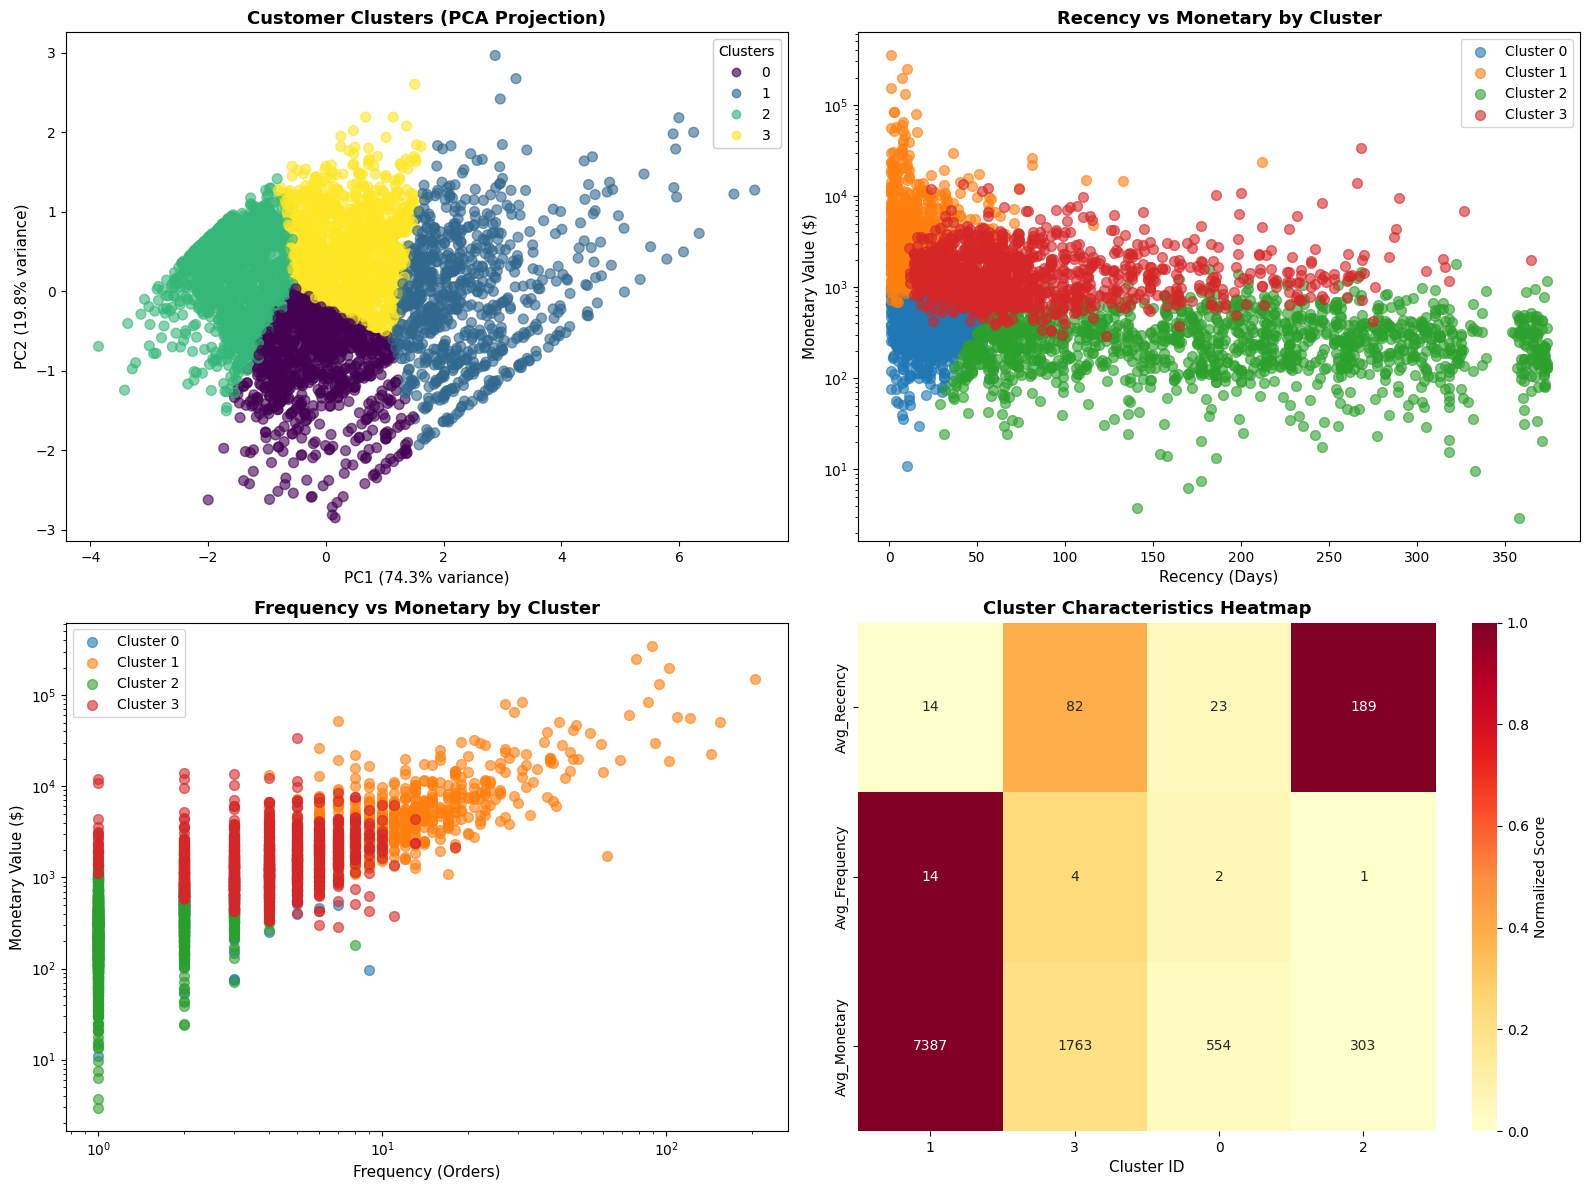

In [11]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

rfm['PCA1'] = X_pca[:, 0]
rfm['PCA2'] = X_pca[:, 1]

# Create cluster visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PCA Scatter Plot
ax1 = axes[0, 0]
scatter = ax1.scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['Cluster'], cmap='viridis', alpha=0.6, s=50)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('Customer Clusters (PCA Projection)', fontsize=13, fontweight='bold')
legend1 = ax1.legend(*scatter.legend_elements(), title="Clusters", loc='upper right')
ax1.add_artist(legend1)

# 2. Recency vs Monetary by Cluster
ax2 = axes[0, 1]
for cluster in sorted(rfm['Cluster'].unique()):
    cluster_data = rfm[rfm['Cluster'] == cluster]
    ax2.scatter(cluster_data['Recency'], cluster_data['Monetary'], 
               label=f'Cluster {cluster}', alpha=0.6, s=50)
ax2.set_xlabel('Recency (Days)', fontsize=11)
ax2.set_ylabel('Monetary Value ($)', fontsize=11)
ax2.set_title('Recency vs Monetary by Cluster', fontsize=13, fontweight='bold')
ax2.legend()
ax2.set_yscale('log')

# 3. Frequency vs Monetary by Cluster
ax3 = axes[1, 0]
for cluster in sorted(rfm['Cluster'].unique()):
    cluster_data = rfm[rfm['Cluster'] == cluster]
    ax3.scatter(cluster_data['Frequency'], cluster_data['Monetary'], 
               label=f'Cluster {cluster}', alpha=0.6, s=50)
ax3.set_xlabel('Frequency (Orders)', fontsize=11)
ax3.set_ylabel('Monetary Value ($)', fontsize=11)
ax3.set_title('Frequency vs Monetary by Cluster', fontsize=13, fontweight='bold')
ax3.legend()
ax3.set_yscale('log')
ax3.set_xscale('log')

# 4. Cluster Comparison Heatmap
ax4 = axes[1, 1]
heatmap_data = cluster_summary[['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']].copy()
# Normalize for heatmap (0-1 scale)
heatmap_data_norm = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())
sns.heatmap(heatmap_data_norm.T, annot=heatmap_data.T, fmt='.0f', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Normalized Score'})
ax4.set_title('Cluster Characteristics Heatmap', fontsize=13, fontweight='bold')
ax4.set_xlabel('Cluster ID', fontsize=11)

plt.tight_layout()
plt.savefig('../reports/customer_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. COMPARE: MANUAL RFM SEGMENTS vs ML CLUSTERS

In [12]:
print("\n" + "="*80)
print("COMPARISON: MANUAL SEGMENTS vs ML CLUSTERS")
print("="*80)

comparison = pd.crosstab(rfm['Segment'], rfm['Cluster_Name'], margins=True)
print(comparison)


COMPARISON: MANUAL SEGMENTS vs ML CLUSTERS
Cluster_Name         New Potentials  Regular Customers  VIP Champions   All
Segment                                                                    
At Risk                           0                681              7   688
Cannot Lose Them                  0                181              0   181
Champions                        30                182            714   926
Lost Customers                    0                833              0   833
Loyal Customers                 266                451             55   772
New Customers                   353                 15              0   368
Others                          248                199              0   447
Potential Loyalists              47                 49              0    96
All                             944               2591            776  4311


## 10. SAVE RESULTS

In [13]:
rfm.to_csv('../data/processed/customer_clusters.csv', index=False)
cluster_summary.to_csv('../data/processed/cluster_summary.csv')

print("\n✅ Clustering complete! Files saved:")
print("   - ../data/processed/customer_clusters.csv")
print("   - ../data/processed/cluster_summary.csv")


✅ Clustering complete! Files saved:
   - ../data/processed/customer_clusters.csv
   - ../data/processed/cluster_summary.csv


## 11. BUSINESS RECOMMENDATIONS BY CLUSTER

In [14]:
print("\n" + "="*80)
print("BUSINESS RECOMMENDATIONS BY CLUSTER")
print("="*80)

recommendations = {
    'VIP Champions': {
        'characteristics': 'High value, recent purchases, frequent buyers',
        'action': 'VIP loyalty program, early access to new products, personalized service',
        'priority': 'HIGH - Protect these customers at all costs'
    },
    'Loyal High-Value': {
        'characteristics': 'Consistent high spenders with good frequency',
        'action': 'Upsell premium products, referral incentives, exclusive offers',
        'priority': 'HIGH - Grow their lifetime value'
    },
    'New Potentials': {
        'characteristics': 'Recent customers but low frequency/spend',
        'action': 'Onboarding campaigns, second-purchase incentives, education content',
        'priority': 'MEDIUM - Convert to loyal customers'
    },
    'At Risk / Churned': {
        'characteristics': 'Haven\'t purchased recently',
        'action': 'Win-back campaigns, special discounts, survey for feedback',
        'priority': 'MEDIUM - Reactivate before lost completely'
    }
}

for cluster_name, rec in recommendations.items():
    if cluster_name in rfm['Cluster_Name'].values:
        count = len(rfm[rfm['Cluster_Name'] == cluster_name])
        revenue = rfm[rfm['Cluster_Name'] == cluster_name]['Monetary'].sum()
        print(f"\n🔹 {cluster_name} ({count} customers, ${revenue:,.0f} revenue)")
        print(f"   Characteristics: {rec['characteristics']}")
        print(f"   Action: {rec['action']}")
        print(f"   Priority: {rec['priority']}")


BUSINESS RECOMMENDATIONS BY CLUSTER

🔹 VIP Champions (776 customers, $5,732,148 revenue)
   Characteristics: High value, recent purchases, frequent buyers
   Action: VIP loyalty program, early access to new products, personalized service
   Priority: HIGH - Protect these customers at all costs

🔹 New Potentials (944 customers, $522,666 revenue)
   Characteristics: Recent customers but low frequency/spend
   Action: Onboarding campaigns, second-purchase incentives, education content
   Priority: MEDIUM - Convert to loyal customers
